In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
from linetools.spectra.xspectrum1d import XSpectrum1D

## The CLAMATO read in

In [2]:
path_16 = "../spectra/2016/"
path_17 = "../spectra/2017/"

spec_atr_16 = Table.read(path_16 + "spec_atr.txt", format='ascii')
spec_atr_17 = Table.read(path_17 + "spec_atr.txt", format='ascii')

z_bin = [2.25,2.75]

### 2016

In [3]:
# read in
spec_16 = []
z_16 = []
coord_16 = []
ID_16 = []

for entry in spec_atr_16:  # from the CLAMATO 2016 survey

    if np.min(z_bin) < entry["zspec"] < np.max(z_bin):  # creating the bin size

        if entry["Conf"] < 10.0:  # excluding any QSOs

            temp = XSpectrum1D.from_file(path_16 + entry["Filename"])

            if temp.wvmin < (1216 * u.AA) * (1 + entry["zspec"]) < temp.wvmax:

                coord_16.append([entry["RA"], entry["Dec"]])  # coordinates in deg

                z_16.append(entry["zspec"])

                spec_16.append(XSpectrum1D.from_file(path_16 + entry["Filename"]))
                
                ID_16.append(entry["Filename"])

In [4]:
len(spec_16)

144

### 2017

In [5]:
spec_17 = []
z_17 = []
coord_17 = []
ID_17 = []

for entry in spec_atr_17:

    if np.min(z_bin) < entry["col5"] < np.max(z_bin):

        if entry["col4"] < 10.0:

            temp = XSpectrum1D.from_file(path_17 + entry["col1"])

            if temp.wvmin < (1216 * u.AA) * (1 + entry["col5"]) < temp.wvmax:

                coord_17.append([entry["col7"], entry["col8"]])

                z_17.append(entry["col5"])
                
                spec_17.append(XSpectrum1D.from_file(path_17 + entry["col1"]))     
                
                ID_17.append(entry["col1"])

/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [6]:
len(spec_17)

269

In [7]:
spec = np.asarray(spec_16 + spec_17)
red = np.asarray(z_16 + z_17)
coord = np.asarray(coord_16 + coord_17)
ID = np.asarray(ID_16 + ID_17)

print("Number of spectra in the redshift bin:", len(spec))

z_16_tot = [entry["zspec"] for entry in spec_atr_16]  # from the CLAMATO 2016 survey
z_17_tot = [entry["col5"] for entry in spec_atr_17]  # from the CLAMATO 2017 survey
z_tot = z_16_tot + z_17_tot

Number of spectra in the redshift bin: 413


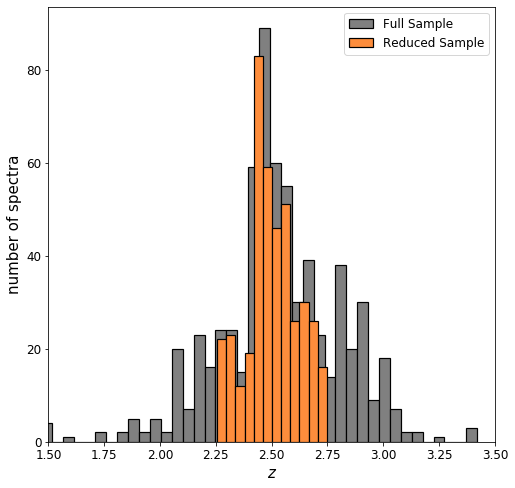

In [8]:
# a histogram to illustrate the sample selected
    
plt.figure(figsize=(8, 8))
    
plt.hist(z_tot, bins=70, edgecolor='black', linewidth=1.2, label="Full Sample", color="grey")
plt.hist(red, bins=12, edgecolor='black', linewidth=1.2, label="Reduced Sample", color="#fd8d3c")
    
plt.ylabel("number of spectra",fontsize=15)
plt.xlabel("$z$",fontsize=15)
    
plt.xlim(1.5, 3.5)
    
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig("../figures/red_hist.pdf")
plt.show()

## Sample cuts

### Lyman Limit cut

In [9]:
print("Number of spectra provided =", len(spec))

r = range(len(spec))

ll_meds = []
ll_cut = []
    
for i in r:
        
    rest_wave = spec[i].wavelength / (1 + red[i]) # rest-frame
                
    sig = np.array(spec[i].sig[rest_wave < 912*u.AA])
        
    flux = np.array(spec[i].flux[rest_wave < 912*u.AA])
    
    try: #take the median
        
        ll_flux = np.sort(flux[sig > 0.0])
        n = len(ll_flux)
        
        if n % 2 == 0: 
            med1 = ll_flux[n//2] 
            med2 = ll_flux[n//2 - 1] 
            median = (med1 + med2)/2
        else:   
            median = ll_flux[n//2] 
        
        ll_meds.append(median)
            
        if (-.2 < median) & (median < .2):     
            ll_cut.append(i)
        
    except IndexError:
        ll_cut.append(i)

Number of spectra provided = 413


In [10]:
ll_meds = np.asarray(ll_meds)
ll_cut = np.asarray(ll_cut)

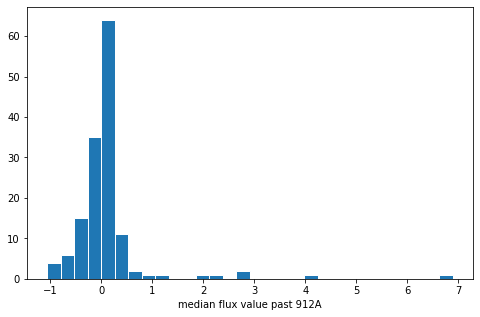

In [11]:
plt.figure(figsize=(8,5))
plt.hist(ll_meds, bins=30, edgecolor="white")
plt.xlabel("median flux value past 912A")
plt.show()

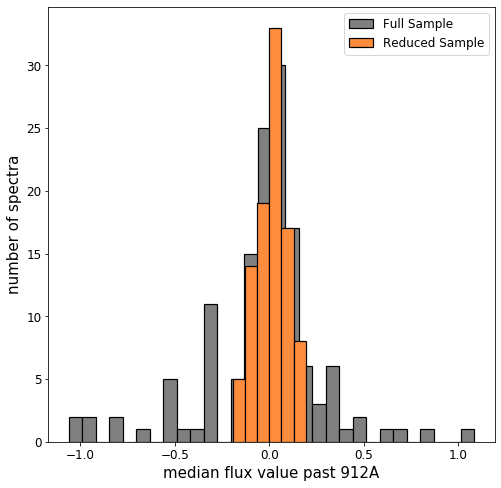

In [12]:
plt.figure(figsize=(8,8))
plt.hist(ll_meds[ll_meds < 1.5], bins=30, edgecolor="black",
         linewidth=1.2, label="Full Sample", color="grey")

plt.hist(ll_meds[(-.2 < ll_meds) & (ll_meds < .2)], bins=6, edgecolor="black",
         linewidth=1.2, label="Reduced Sample", color="#fd8d3c")

plt.xlabel("median flux value past 912A",fontsize=15)
plt.ylabel("number of spectra",fontsize=15)

plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [13]:
spec = spec[ll_cut]
red = red[ll_cut]
coord = coord[ll_cut]
ID = ID[ll_cut]

print("Number of spectra left after the lyman-limit cut = ", len(spec))

Number of spectra left after the lyman-limit cut =  364


### S/N cut

In [14]:
# now we exlcude any galaxies below the s2n
print("Number of spectra provided =", len(spec))

r = range(len(spec))

s2n = 1.5

temp = [np.asarray(spec[i].wavelength / (1 + red[i])) for i in r]  # rest-frame

good = [(1260 < entry) & (entry < 1304) for entry in temp] # masking to find a good region

signal = np.asarray([spec[i].flux[good[i]] for i in r])

noise = np.asarray([spec[i].sig[good[i]] for i in r])

s2n_array = np.asarray([np.median(signal[i] / noise[i]) for i in r])

s2n_cut = [i > s2n for i in s2n_array]

Number of spectra provided = 364


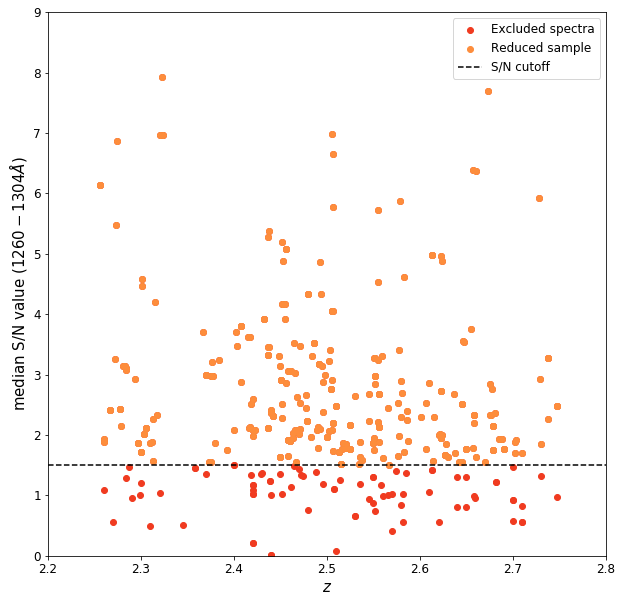

In [27]:
#plot!
    
plt.figure(figsize=(10,10))
    
plt.scatter(red, s2n_array, label="Excluded spectra", color="#f03b20")
plt.scatter(red[s2n_cut], s2n_array[s2n_cut], label="Reduced sample", color="#fd8d3c")
                
plt.hlines(s2n,2.2, 2.8, linestyle="--", color="black",label="S/N cutoff")
plt.ylabel("median S/N value ($1260 - 1304\AA$)",fontsize=15)
plt.xlabel("$z$",fontsize=15)
plt.ylim(0,9)
    
    
plt.xlim(2.2, 2.8)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
    
#plt.savefig("../figures/s2n_hist.pdf")
plt.show()

In [28]:
#cut!
spec = spec[s2n_cut]
red = red[s2n_cut]
coord = coord[s2n_cut,:]
ID = ID[s2n_cut]
    
print("Number of spectra left after the S/N cut = ", len(spec))

Number of spectra left after the S/N cut =  281


In [29]:
spec_info = Table([ID, coord[:,0], coord[:,1], red], names=("CLAMAT ID", "RA", "DEC", "z"))

#spec_info.write("yeeha", format="latex")